In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_5.csv")


In [20]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["messageSizeBytes"] = dataFrame["messageSizeBytes"].astype(int)
dataFrame["numMessages"] = dataFrame["numMessages"].astype(int)
dataFrame["computeMicroseconds"] = dataFrame["computeMicroseconds"].astype(int)
dataFrame["numIterations"] = dataFrame["numIterations"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["totalTimeSeconds"] = dataFrame["totalTimeSeconds"].astype(float)
dataFrame["avgTimePerIteration"] = dataFrame["avgTimePerIteration"].astype(float)
dataFrame["bandwidthBytesPerSec"] = dataFrame["bandwidthBytesPerSec"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Message sizes:", sorted(dataFrame["messageSizeBytes"].unique()))
print("NumMessages:", sorted(dataFrame["numMessages"].unique()))
print("Compute microseconds:", sorted(dataFrame["computeMicroseconds"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 1200
Message sizes: [1, 64, 1024, 65536, 262144]
NumMessages: [1, 4, 16, 32]
Compute microseconds: [10, 50, 100]
Process counts: [2, 4, 6, 8]


,testType,messageSizeBytes,numMessages,computeMicroseconds,numIterations,numProcesses,totalTimeSeconds,avgTimePerIteration,bandwidthBytesPerSec,runIndex,mpiEnv
0,MPI_5,1,1,10,2000,2,0.000451,2.260000e-07,4432624.671,1,PROCS=2
1,MPI_5,1,1,10,2000,2,0.000501,2.510000e-07,3988036.076,2,PROCS=2
2,MPI_5,1,1,10,2000,2,0.000486,2.430000e-07,4113532.736,3,PROCS=2
3,MPI_5,1,1,10,2000,2,0.000922,4.610000e-07,2168491.725,4,PROCS=2
4,MPI_5,1,1,10,2000,2,0.000486,2.430000e-07,4118616.380,5,PROCS=2
5,MPI_5,1,1,10,2000,4,0.000563,2.810000e-07,3554291.951,1,PROCS=4
6,MPI_5,1,1,10,2000,4,0.000413,2.060000e-07,4844961.240,2,PROCS=4
7,MPI_5,1,1,10,2000,4,0.000506,2.530000e-07,3954913.911,3,PROCS=4


In [21]:
groupedFrame = dataFrame.groupby(["messageSizeBytes","numMessages","computeMicroseconds","numIterations","numProcesses"], as_index=False).agg(
    median=("totalTimeSeconds","median"),
    mean=("totalTimeSeconds","mean"),
    std=("totalTimeSeconds","std"),
    count=("totalTimeSeconds","count"),
    medianAvgIter=("avgTimePerIteration","median"),
    medianBandwidth=("bandwidthBytesPerSec","median")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["computeMicroseconds","numMessages","messageSizeBytes","numProcesses"]).reset_index(drop=True)
groupedFrame.head(12)


,messageSizeBytes,numMessages,computeMicroseconds,numIterations,numProcesses,median,mean,std,count,medianAvgIter,medianBandwidth
0,1,1,10,2000,2,0.000486,0.000569,0.000198,5,2.430000e-07,4.113533e+06
1,1,1,10,2000,4,0.000424,0.000464,0.000067,5,2.120000e-07,4.713646e+06
2,1,1,10,2000,6,0.000712,0.000910,0.000505,5,3.560000e-07,2.808594e+06
3,1,1,10,2000,8,0.000699,0.000722,0.000089,5,3.500000e-07,2.860821e+06
4,64,1,10,2000,2,0.000401,0.000418,0.000032,5,2.010000e-07,3.191224e+08
5,64,1,10,2000,4,0.000541,0.000612,0.000213,5,2.710000e-07,2.363805e+08
6,64,1,10,2000,6,0.000651,0.000638,0.000032,5,3.260000e-07,1.965300e+08
7,64,1,10,2000,8,0.000675,0.001809,0.002557,5,3.370000e-07,1.896858e+08
8,1024,1,10,1000,2,0.000283,0.000288,0.000014,5,2.830000e-07,3.615820e+09
9,1024,1,10,1000,4,0.000305,0.000322,0.000029,5,3.050000e-07,3.355177e+09


In [ ]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    groupKeys = ["messageSizeBytes","numMessages","computeMicroseconds","numIterations"]
    for keys, sub in groupedDf.groupby(groupKeys):
        baseRows = sub[sub["numProcesses"] == 2]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = sub.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,messageSizeBytes,numMessages,computeMicroseconds,numIterations,numProcesses,median,mean,std,count,medianAvgIter,medianBandwidth,speedup,efficiency
0,1,1,10,2000,2,0.000486,0.000569,0.000198,5,2.430000e-07,4113532.736,1.000000,0.500000
1,1,1,10,2000,4,0.000424,0.000464,0.000067,5,2.120000e-07,4713646.325,1.146226,0.286557
2,1,1,10,2000,6,0.000712,0.000910,0.000505,5,3.560000e-07,2808594.493,0.682584,0.113764
3,1,1,10,2000,8,0.000699,0.000722,0.000089,5,3.500000e-07,2860821.186,0.695279,0.086910
4,1,1,50,2000,2,0.000468,0.000477,0.000025,5,2.340000e-07,4278074.250,1.000000,0.500000
5,1,1,50,2000,4,0.000436,0.000442,0.000028,5,2.180000e-07,4590315.052,1.073394,0.268349
6,1,1,50,2000,6,0.000569,0.000611,0.000179,5,2.840000e-07,3518029.770,0.822496,0.137083
7,1,1,50,2000,8,0.000697,0.000762,0.000142,5,3.480000e-07,2869852.403,0.671449,0.083931
8,1,1,100,2000,2,0.000457,0.000454,0.000053,5,2.280000e-07,4377325.583,1.000000,0.500000
9,1,1,100,2000,4,0.000492,0.000549,0.000108,5,2.460000e-07,4064214.410,0.928862,0.232215


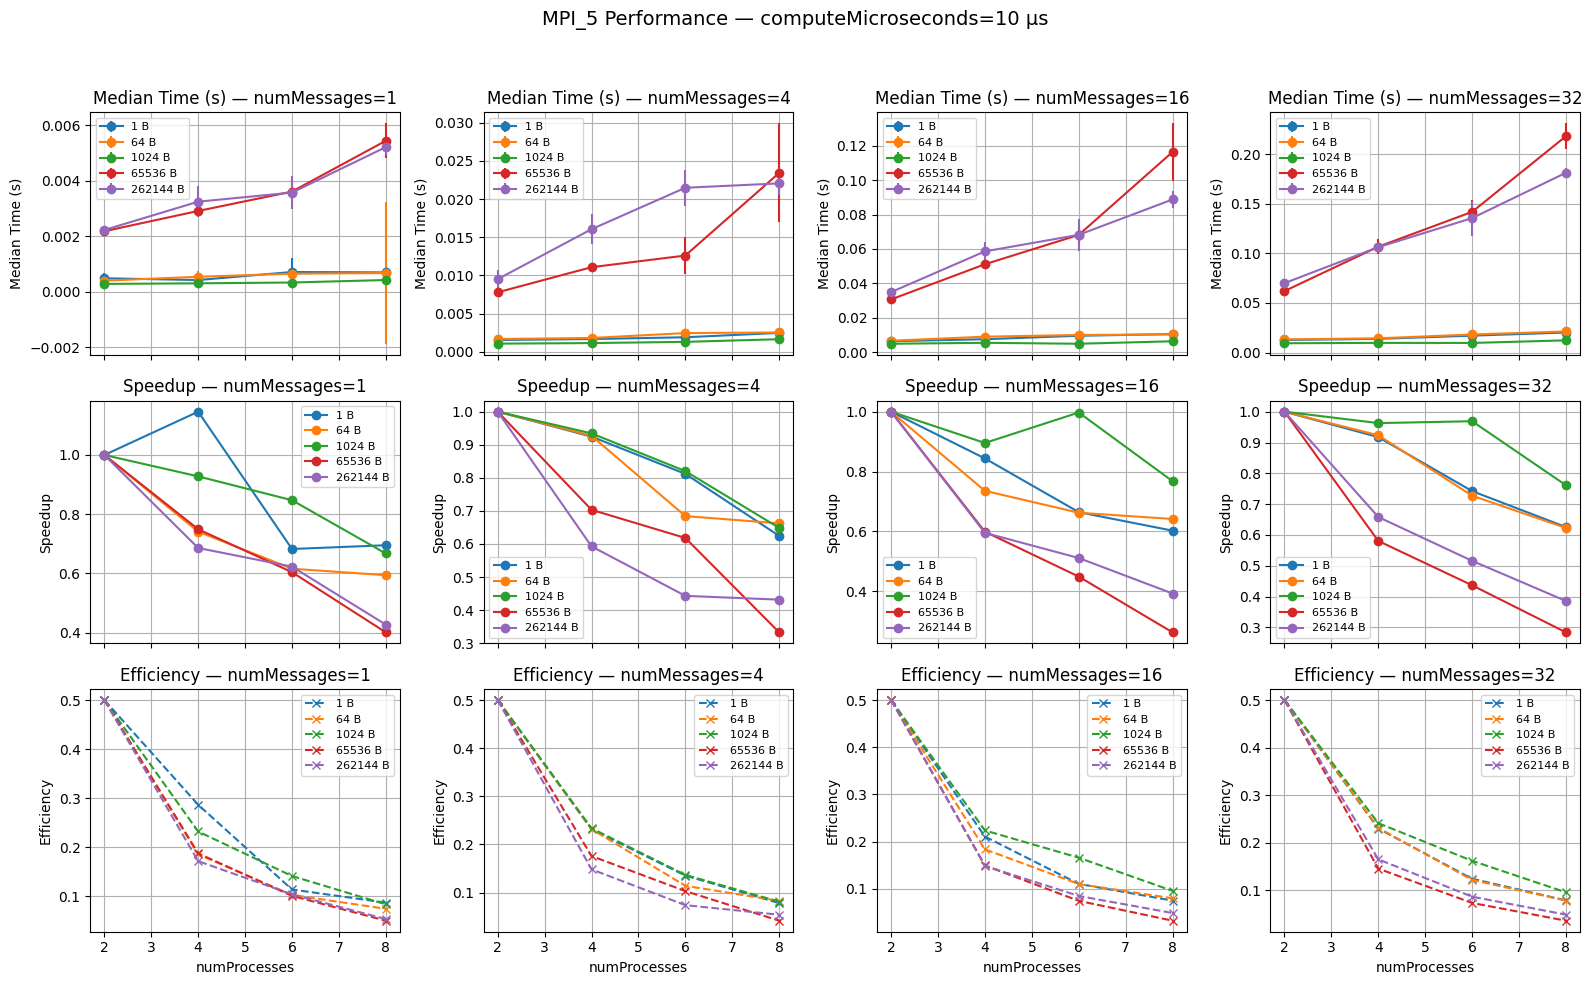

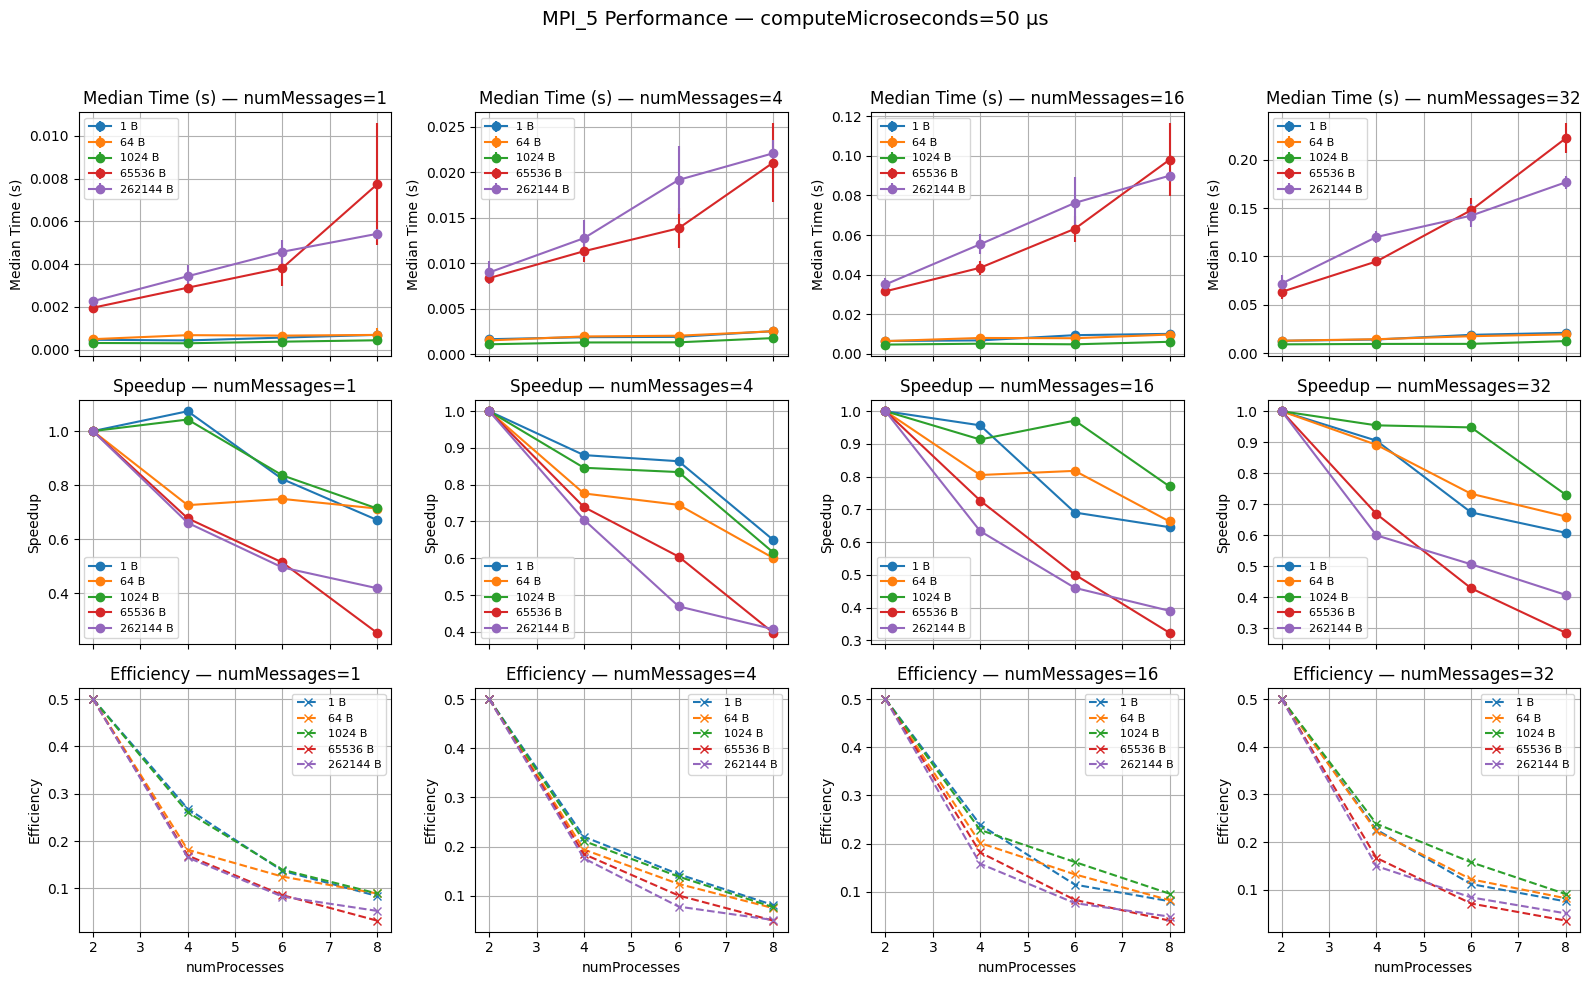

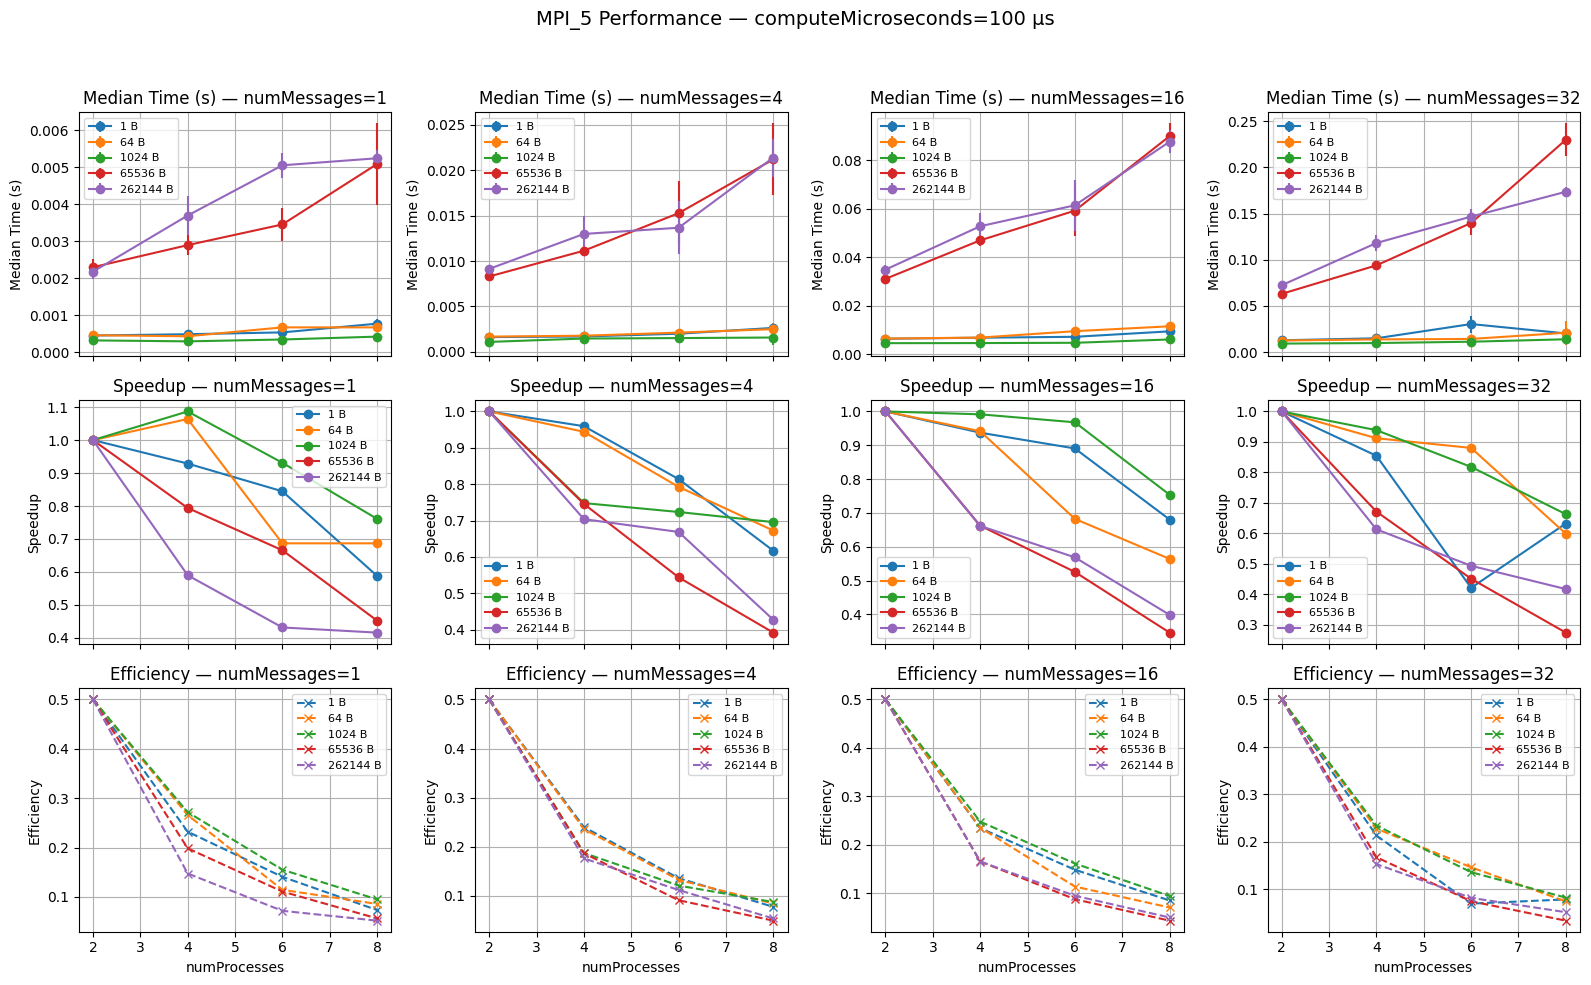

In [23]:
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

messageSizeList = sorted(perfFrame["messageSizeBytes"].unique())
computeMicroList = sorted(perfFrame["computeMicroseconds"].unique())
numMessagesList = sorted(perfFrame["numMessages"].unique())

for computeMicroVal in computeMicroList:
    filterByCompute = perfFrame[perfFrame["computeMicroseconds"] == computeMicroVal]
    if filterByCompute.empty:
        print(f"No data for computeMicroseconds={computeMicroVal}")
        continue

    numCols = max(1, len(numMessagesList))
    fig, axes = plt.subplots(len(metrics), numCols, figsize=(4 * numCols, 10), sharex=True)
    if len(metrics) == 1 and numCols == 1:
        axes2d = np.array([[axes]])
    elif len(metrics) == 1:
        axes2d = np.array([axes])
    elif numCols == 1:
        axes2d = np.array([[ax] for ax in axes])
    else:
        axes2d = axes

    for colIdx, numMessagesVal in enumerate(numMessagesList):
        for rowIdx, metric in enumerate(metrics):
            ax = axes2d[rowIdx][colIdx]
            subForMessages = filterByCompute[filterByCompute["numMessages"] == numMessagesVal]
            if subForMessages.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                ax.set_title(f"numMessages={numMessagesVal}")
                ax.grid(True)
                continue

            for messageSizeVal in messageSizeList:
                subFrame = subForMessages[subForMessages["messageSizeBytes"] == messageSizeVal].sort_values("numProcesses")
                if subFrame.empty:
                    continue
                x = subFrame["numProcesses"].values
                y = subFrame[metric].values
                labelStr = f"{messageSizeVal} B"
                if metric == "median":
                    yerr = subFrame["std"].values
                    ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=labelStr)
                else:
                    linestyle = '-' if metric == 'speedup' else '--'
                    markerStyle = 'o' if metric == 'speedup' else 'x'
                    ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=labelStr)

            ax.set_title(f"{metricLabels[metric]} — numMessages={numMessagesVal}")
            if rowIdx == len(metrics) - 1:
                ax.set_xlabel("numProcesses")
            ax.set_ylabel(metricLabels[metric])
            ax.grid(True)
            ax.legend(fontsize=8)

    plt.suptitle(f"MPI_5 Performance — computeMicroseconds={computeMicroVal} µs", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


In [24]:
summaryRows = []
for (messageSizeVal, numMessagesVal, computeMicroVal, numIterationsVal), sub in perfFrame.groupby(["messageSizeBytes","numMessages","computeMicroseconds","numIterations"]):
    if sub.empty:
        continue
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestProcs = int(argMax["numProcesses"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numProcesses"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "messageSizeBytes": messageSizeVal,
        "numMessages": numMessagesVal,
        "computeMicroseconds": computeMicroVal,
        "numIterations": numIterationsVal,
        "bestNumProcesses": bestProcs,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Proc": medianAtOne
    })
summaryFrame = pd.DataFrame(summaryRows).sort_values(["computeMicroseconds","numMessages","messageSizeBytes"])
display(summaryFrame)


,messageSizeBytes,numMessages,computeMicroseconds,numIterations,bestNumProcesses,maxSpeedup,efficiencyAtBest,medianTime1Proc
0,1,1,10,2000,4,1.146226,0.286557,NaN
12,64,1,10,2000,2,1.000000,0.500000,NaN
24,1024,1,10,1000,2,1.000000,0.500000,NaN
36,65536,1,10,500,2,1.000000,0.500000,NaN
48,262144,1,10,200,2,1.000000,0.500000,NaN
3,1,4,10,2000,2,1.000000,0.500000,NaN
15,64,4,10,2000,2,1.000000,0.500000,NaN
27,1024,4,10,1000,2,1.000000,0.500000,NaN
39,65536,4,10,500,2,1.000000,0.500000,NaN
51,262144,4,10,200,2,1.000000,0.500000,NaN
